# Working with the USHMM PDFs

This is the first of a series of notebooks that will guide you through processing oral interview PDFs from the United States Holocaust Memorial Museum. These notebooks, along with several datasets and machine learning models, are an output of the NEH-funded Placing the Holocaust Project. A collection of these PDFs, which are in English exclusively, are available on HuggingFace [here](https://huggingface.co/datasets/placingholocaust/ushmm-pdfs).

## Objective of Notebook

This notebook will:

- Walk through the steps of downloading the PDFs from HuggingFace
- Demonstrate how to use the `ushmm` Python package for processing the PDFs.

This will be the most computationally expensive portion of the workflow.

## Getting Started

In order to work with this notebook, you will need to have several packages already installed. To install these packages, you can use the `requirements.txt` file. Or, you can install these with the following pip command inside this notebook:

In [1]:
!pip install ushmm huggingface-hub tqdm diff_match_patch

### About the Packages

- `ushmm`: This is a Python package designed to work with various data available from the USHMM. We use it in this project to process oral history PDFs.
- `huggingface-hub`: This is a Python package that functions as an API with HuggingFace. This allows us to download the PDFs individually as we process them.
- `tqdm`: This is a Python package that allows us to visualize processes with a progress bar.
- `diff_match_patch`: This is a Python package that allows us to analyze the differences between two data.


### Importing the Packages

Now that we have installed everything, let's go ahead and import the required packages for this notebook.


In [2]:
# Allows us to move the notebook out of examples/ so we can access the /src Python files more clearly.
import os
os.chdir('..')

from ushmm import pdf_to_images, images_to_text, clean_texts, remove_footers, process_testimony_texts
from huggingface_hub import hf_hub_download, list_repo_files

from src.visualization.visualize import visualize_diff
from src.data.clean import clean_html

## Workflow

### Downloading the Data

It is important that users trying to replicate our workflow are working from a standard data source. For this reason we have uploaded the PDFs to HuggingFace. Let's go ahead and first specify the `repo_id` that we will be working with `placingholocaust/ushmm-pdfs`. This `repo_id` has two components: the organization name, `placingholocaust` and the repository, `ushmm-pdfs`.

In [3]:
repo_id = "placingholocaust/ushmm-pdfs"

To access the pdfs, we can use the `list_repo_files` function from `huggingface-hub`. This will take two arguments: the `repo_id` and the `repo_type`. Because this is a dataset, we will specify that we are loading a `dataset`.

In [4]:
pdfs = list_repo_files(repo_id, repo_type="dataset")

At this stage, we don't have the original PDFs, rather a list of the files available to us. This will be an entire list of all contents in the repository. This means, we have our `git` files included, such as `.gitattributes`. Our actual PDFs sit inside the `pdfs` directory.

In [5]:
pdfs[:5]

['.gitattributes',
 'pdfs/RG-50.030.0001_trs_en.pdf',
 'pdfs/RG-50.030.0002_trs_en.pdf',
 'pdfs/RG-50.030.0003_trs_en.pdf',
 'pdfs/RG-50.030.0004_trs_en.pdf']

Let's also examine the total number of files we have.

In [6]:
len(pdfs)

1611

As you can see, we have 1610 PDFs (excluding .gitattributes).

To download a PDF, we can use the `hf_hub_download` function. This will let us specify the `repo_id`, `filename`, `local_dir` (the place want to save the data), and `repo_type`. Here's an example of how we can pass the first PDF to this function:

In [7]:
demo_directory = "demo_output"
clean_filename = "pdfs/RG-50.030.0001_trs_en"
os.makedirs(demo_directory, exist_ok=True)

In [8]:
hf_hub_download(repo_id="placingholocaust/ushmm-pdfs", filename="pdfs/RG-50.030.0001_trs_en.pdf", local_dir=demo_directory, repo_type="dataset")

RG-50.030.0001_trs_en.pdf:   0%|          | 0.00/260k [00:00<?, ?B/s]

'demo_data/pdfs/RG-50.030.0001_trs_en.pdf'

As we can see, this has now saved the file in `../data/`. It followed the structure of the repository and placed the PDF inside the subdirectory `pdfs`. At this stage, we can now begin working with the PDF.

### Processing a PDF

The first thing that we need to do is convert the PDFs into a series of images. This will allow us to effectively process them via an OCR pipeline. To convert the PDF to images, we can use the `pdf_to_images` function from `ushmm`. This step essentially wraps around the `pdf2image` library.

In [9]:
images = pdf_to_images(f"./{demo_directory}/{clean_filename}.pdf", f"./{demo_directory}/{clean_filename}/images", save=True)

Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0001.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0002.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0003.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0004.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0005.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0006.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0007.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0008.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0009.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0010.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0011.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0012.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0013.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0014.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0015.jpg
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/images/0016.jpg
Saved: .

Let's take a look at one of these images.

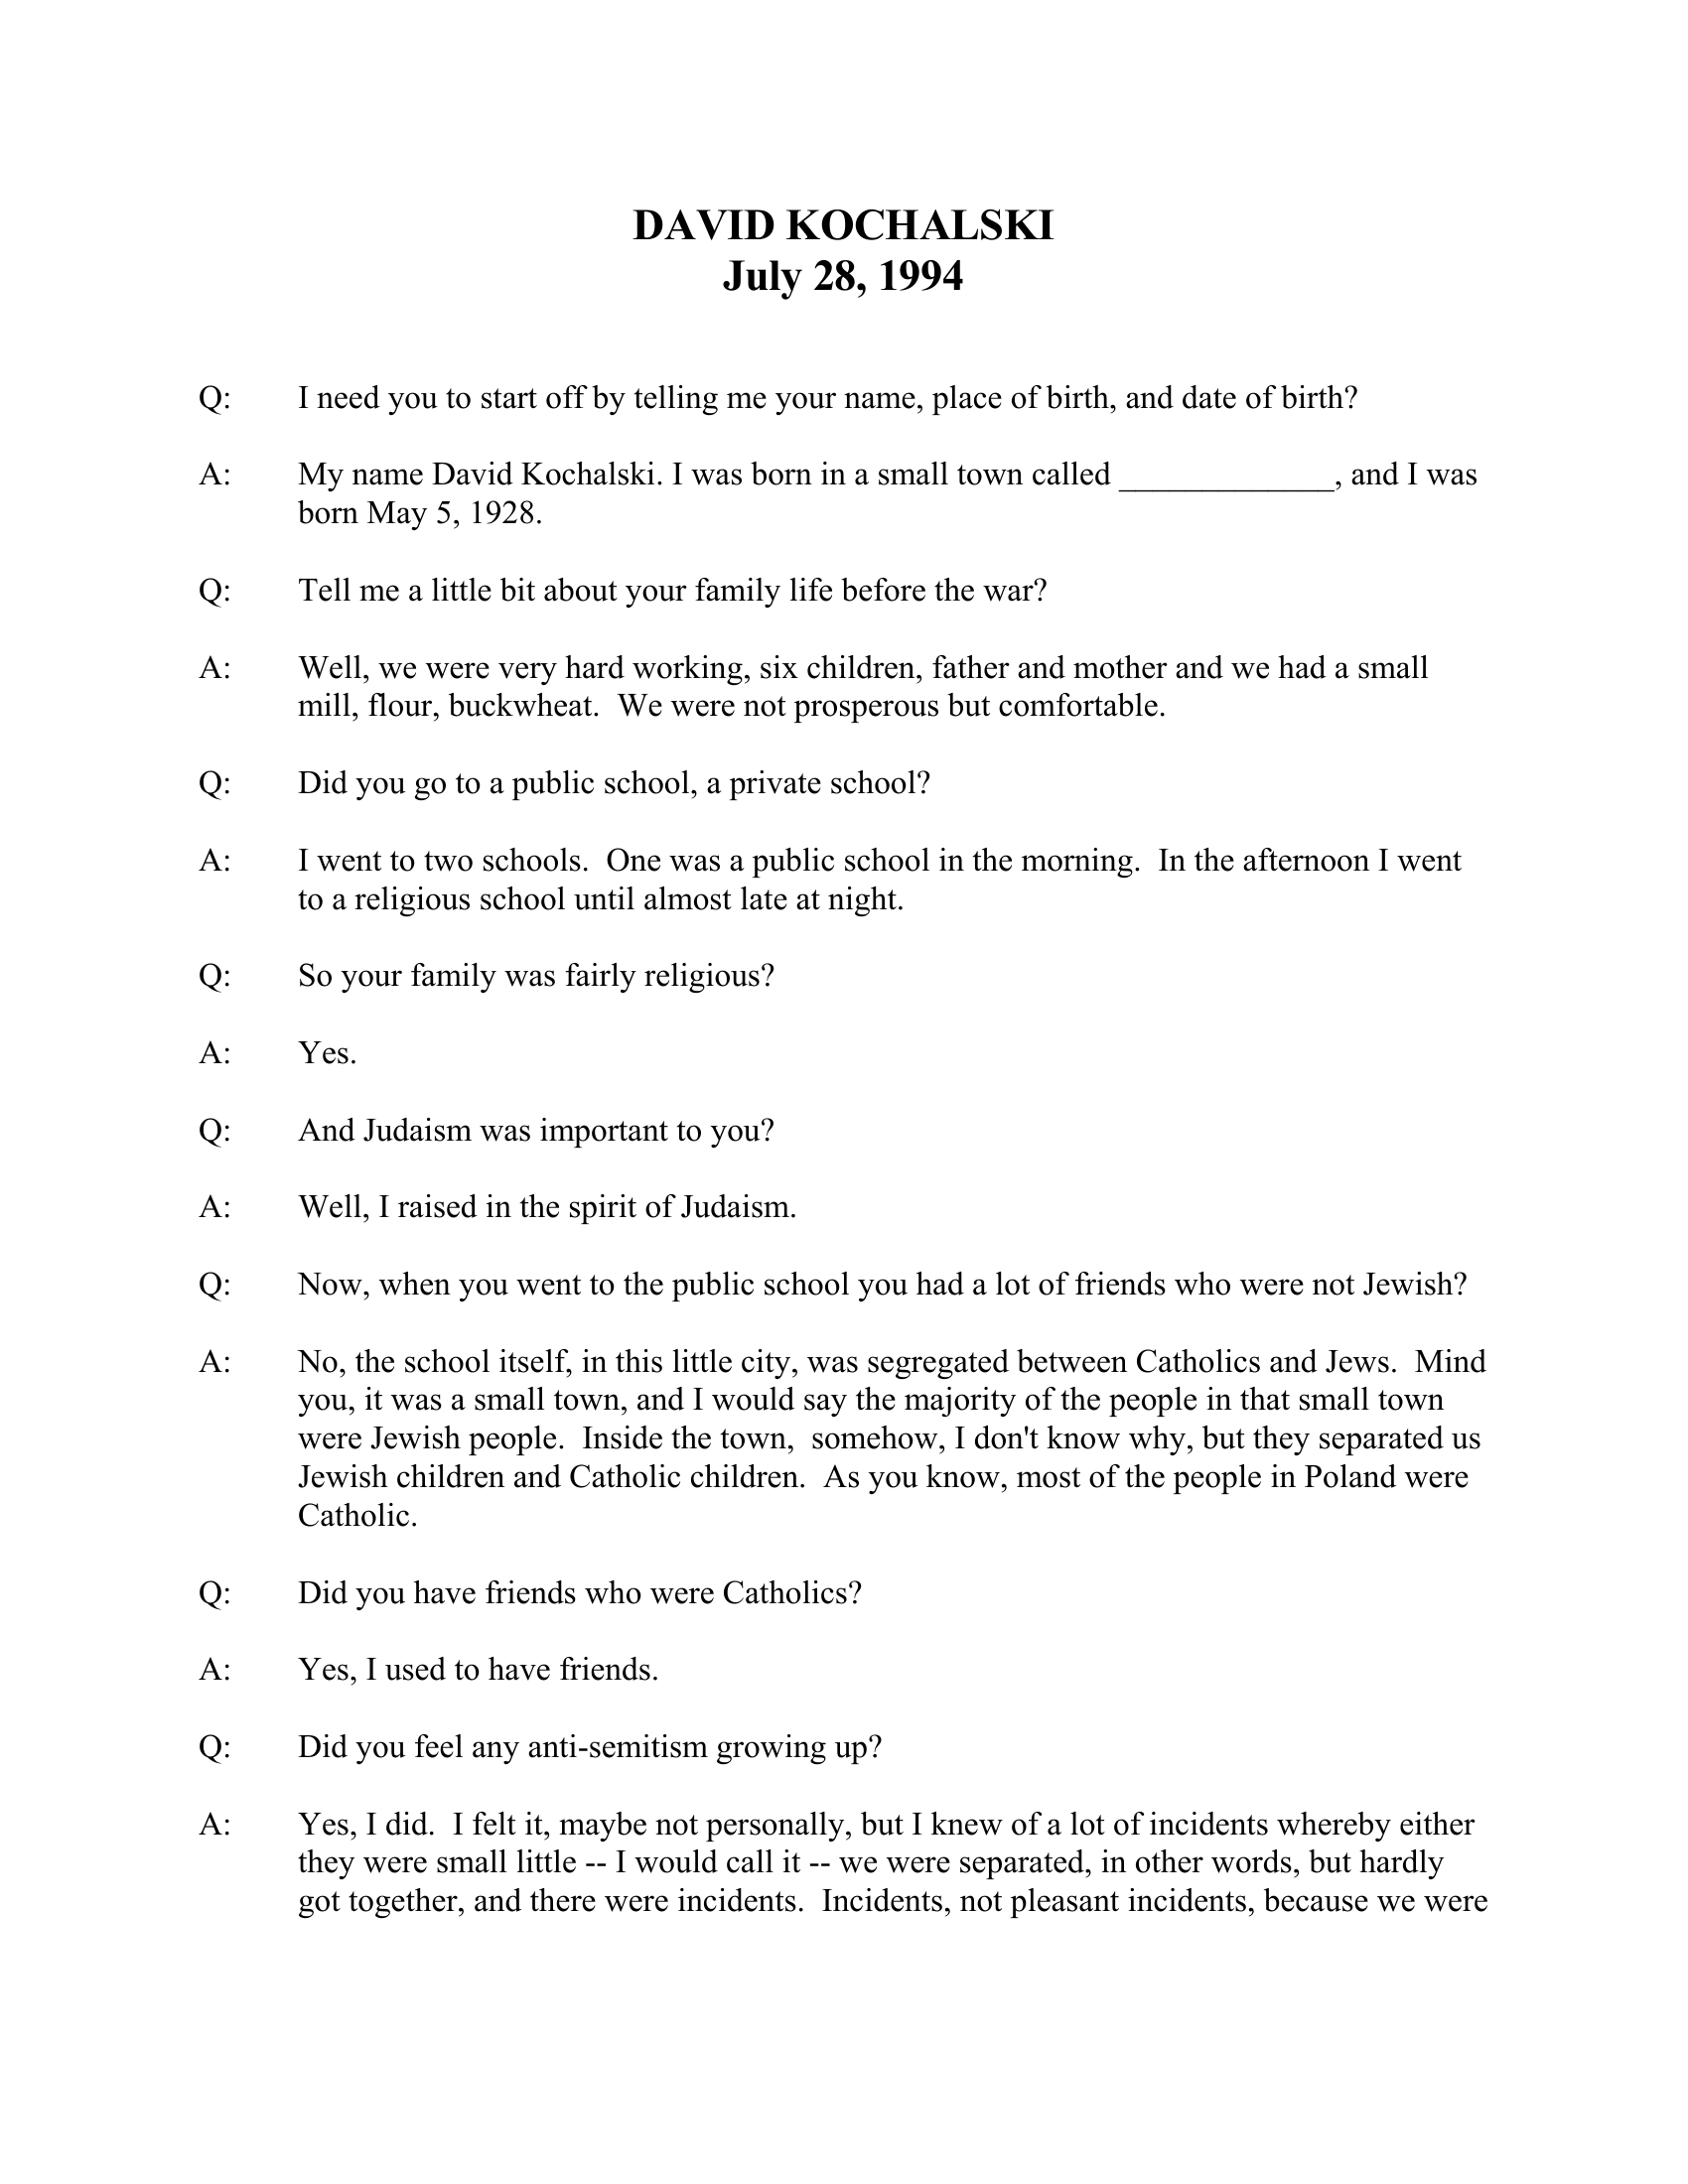

In [10]:
images[2]

### Cropping the Image

Now that we have converted the PDF to a series of images, we now need to focus on a key challenge with the image: isolating the main body of the text. Some pages contain footers which function as footnotes. These are often identified with a long line. We can use this feature to flag and remove footers. The `ushmm` function `remove_footers` takes a directory of images, flags pages where footers appear, and removes the footer. It then saves the images in a new directory. This is achieved via OpenCV.

In [11]:
cropped_images = remove_footers(f'./{demo_directory}/{clean_filename}/images', output_directory=f'./{demo_directory}/{clean_filename}/images_cropped', save=True)

Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0001.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0002.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0003.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0004.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0005.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0006.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0007.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0008.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0009.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0010.jpg
Processed image saved at: ./demo_data/pdfs/RG-50.030.0001_trs_en/images_cropped/0011.jpg
Processed image saved

### OCR

Now that we have isolated the main body of the text, we can perform OCR. During this step, we will pass each cropped image to Tesseract, an OCR Engine from Google. This process will be handled automatically via the `ushmm` function `images_to_text`.

In [12]:
texts = images_to_text(f"./{demo_directory}/{clean_filename}/images_cropped", output_folder=f"./{demo_directory}/{clean_filename}/text", save=True)

Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0001.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0002.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0003.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0004.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0005.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0006.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0007.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0008.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0009.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0010.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0011.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0012.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0013.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0014.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0015.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_trs_en/text/0016.txt
Saved: ./demo_data/pdfs/RG-50.030.0001_t

### Post-OCR Correction

Unfortunately, the OCR that we receive from Tesseract has a few issues, namely the text may not be normalized. For example, quotation marks may be inconsistently rendered. In addition to this, header material will often time be inserted into the text which will make downstream data analysis more challenging. Finally, line breaks will be rendered inconsistently which can often break up the natural flow of the text. To correct these types of issues, we can again use `ushmm`, but this time the `clean_text` function that performs these types of data cleaning.

This function is verbose and will output the corrections it makes.

In [13]:
processed_texts = clean_texts(f"./{demo_directory}/{clean_filename}/text", output_directory=f"./{demo_directory}/{clean_filename}/clean_text", save=True)

0007.txt
Header Found: USHMM Archives RG-50.030*0001 5
Normalizing characters...
Normalizing quotes...
0013.txt
Header Found: USHMM Archives RG-50.030*0001 11
Normalizing characters...
Normalizing quotes...
0012.txt
Header Found: USHMM Archives RG-50.030*0001 10
Normalizing characters...
Normalizing quotes...
Changed: ' -> "
0006.txt
Header Found: USHMM Archives RG-50.030*0001 4
Normalizing characters...
Normalizing quotes...
0010.txt
Header Found: USHMM Archives RG-50.030*0001 8
Normalizing characters...
Normalizing quotes...
0004.txt
Header Found: USHMM Archives RG-50.030*0001 2
Normalizing characters...
Normalizing quotes...
0005.txt
Header Found: USHMM Archives RG-50.030*0001 3
Normalizing characters...
Normalizing quotes...
0011.txt
Header Found: USHMM Archives RG-50.030*0001 9
Normalizing characters...
Normalizing quotes...
0015.txt
Header Found: USHMM Archives RG-50.030*0001 13
Normalizing characters...
Normalizing quotes...
0001.txt
Normalizing characters...
Normalizing quotes.

Let's examine two pages side-by-side. We can do this with a custom function inside `src/visualize.py` called `visualize_diff`

In [14]:

page_file = "0012.txt"
with open(f"./{demo_directory}/{clean_filename}/text/{page_file}", "r", encoding="utf-8") as f:
    original_text = f.read()
with open(f"./{demo_directory}/{clean_filename}/clean_text/{page_file}", "r", encoding="utf-8") as f:
    clean_text = f.read()

visualize_diff(original_text, clean_text)

Similarity Score: 0.99


As we can see there were minimal changes on this page. The key change was the removal of the header.

## Convert to HTML

At this stage, our text is mostly clean. Further steps are necessary, however, to analyze better these data. The biggest limitation at this stage is that are text remains unstructured. By this I mean our text is entirely unannotated. We cannot, for example, separate the questions from the answers automatically. To convert these testimonies from raw text to structured data, we will use the `ushmm` function `process_testimony_texts`. This will take a directory of the cleaned text files. It will output a single HTML file that is formatted.

This process will automatically identify the key structure of the pages and align them. Most importantly, it will use HTML tags to identify important features of the original data, such as page breaks. Although not perfect, it also attempts to preserve the original paragraphs of the PDF with `<p>` tags. Sections of dialogue receive a `<dialogue>` tag. The dialogue `class` defines what type of dialogue it is. For example, a dialogue can empty (No determined class), `Question` or `Answer`. This is determined by the presence a specific indication at the start of a dialogue sequence.

In [15]:
html_result = process_testimony_texts(f'./{demo_directory}/{clean_filename}/clean_text', output_file=f"{demo_directory}/demo.html", save=True)
print(html_result)

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<title>Document</title>
</head>
<body><dialogue class="Answer"><p>DAVID KOCHALSKI July 28, 1994</p></dialogue>
<dialogue class="Question"><p> Q: I need you to start off by telling me your name, place of birth, and date of birth?</p></dialogue>
<dialogue class="Answer"><p> A: My name David Kochalski. I was born in a small town called , and I was born May 5, 1928.</p></dialogue>
<dialogue class="Question"><p> Q: Tell me a little bit about your family life before the war?</p></dialogue>
<dialogue class="Answer"><p> A: Well, we were very hard working, six children, father and mother and we had a small mill, flour, buckwheat. We were not prosperous but comfortable.</p></dialogue>
<dialogue class="Question"><p> Q: Did you go to a public school, a private school?</p></dialogue>
<dialogue class="Answer"><p> A: I went to two schools. One was a public school in the morning. In the afternoon I went to a religious school until almost l

## Further Cleaning

At this stage, we have outputted a single HTML file using the `ushmm` library. Unfortunately, our work is not quite done. The `ushmm` package is meant to provide generic data cleaning methods. Some PDFs require further cleaning.

In [16]:
cleaned_html = clean_html(f"{demo_directory}/demo.html", output_dir=f"{demo_directory}")


No removals made in demo_data/demo.html
Cleaned HTML saved to: demo_data/demo_cleaned.html


In [17]:
cleaned_html

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Document</title>
</head>
<body><dialogue class=""><p><p>DAVID KOCHALSKI July 28, 1994</p></p></dialogue>
<dialogue class=""><p></p></dialogue><dialogue class="Question"><p><p>Q: I need you to start off by telling me your name, place of birth, and date of birth?</p></p></dialogue>
<dialogue class=""><p></p></dialogue><dialogue class="Answer"><p><p>A: My name David Kochalski. I was born in a small town called , and I was born May 5, 1928.</p></p></dialogue>
<dialogue class=""><p></p></dialogue><dialogue class="Question"><p><p>Q: Tell me a little bit about your family life before the war?</p></p></dialogue>
<dialogue class=""><p></p></dialogue><dialogue class="Answer"><p><p>A: Well, we were very hard working, six children, father and mother and we had a small mill, flour, buckwheat. We were not prosperous but comfortable.</p></p></dialogue>
<dialogue class=""><p></p></dialogue><dialogue class="Question"><p><p>Q: Did y